In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

File and Data Field Descriptions

    train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
        PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
        HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
        CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
        Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
        Destination - The planet the passenger will be debarking to.
        Age - The age of the passenger.
        VIP - Whether the passenger has paid for special VIP service during the voyage.
        RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
        Name - The first and last names of the passenger.
        Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
    test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
    sample_submission.csv - A submission file in the correct format.
        PassengerId - Id for each passenger in the test set.
        Transported - The target. For each passenger, predict either True or False.


In [64]:
# Import libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
import missingno as msno
sns.set_style("darkgrid")

In [65]:
def percent_null(data, col):
    null = data[col].isnull().sum()
    null_percent = null / len(data[col])
    return round(null_percent, 2)

In [66]:
# Removing the _ in the passenger ID's
def remove_underscore(data, col):
    for name, value in data[col].iteritems():
        if '_' in value:
            data[col] = data[col].str.replace('_', '')
    return data

In [67]:
def change_index(data, col):
    data.set_index(col, inplace=True)
    return data

In [68]:
def change_data_type(data, type, col):
    data[col] = data[col].astype(type)
    return data

In [69]:
def rename_cols(data, col, new_name):
    print(col)
    print(new_name)
    for i in col:
        data.rename(columns={col[i]: new_name[i]})
    return data

In [70]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [71]:
df_train.tail()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False
8692,9280_02,Europa,False,E/608/S,TRAPPIST-1e,44.0,False,126.0,4688.0,0.0,0.0,12.0,Propsh Hontichre,True


In [72]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [73]:
list(df_train.columns)

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name',
 'Transported']

In [74]:
list(df_test.columns)

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name']

In [75]:
df_train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [76]:
df_test.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object

In [77]:
df_train.shape

(8693, 14)

In [78]:
df_train.rename(columns={'PassengerId': 'passenger_id', 'HomePlanet': 'home_planet', 'CryoSleep': 'cryo_sleep', 'Cabin': 'cabin', 'Destination': 'destination', 'Age': 'age',
                 'VIP': 'vip', 'RoomService': 'room_service', 'FoodCourt': 'food_court', 'ShoppingMall': 'shopping_mall', 'Spa': 'spa', 'VRDeck': 'vr_deck',
                 'Name': 'name', 'Transported': 'transported'}, inplace=True)

In [79]:
df_test.rename(columns={'PassengerId': 'passenger_id', 'HomePlanet': 'home_planet', 'CryoSleep': 'cryo_sleep', 'Cabin': 'cabin', 'Destination': 'destination', 'Age': 'age',
                 'VIP': 'vip', 'RoomService': 'room_service', 'FoodCourt': 'food_court', 'ShoppingMall': 'shopping_mall', 'Spa': 'spa', 'VRDeck': 'vr_deck',
                 'Name': 'name', 'Transported': 'transported'}, inplace=True)

In [80]:
df_train[['deck', 'num', 'side']] = df_train['cabin'].str.split('/', expand = True).fillna('Missing')

In [81]:
columns = ['cryo_sleep', 'deck', 'num','side', 'age', 'vip', ]
df_train[columns].head()

,cryo_sleep,deck,num,side,age,vip
0,False,B,0,P,39.0,False
1,False,F,0,S,24.0,False
2,False,A,0,S,58.0,True
3,False,A,0,S,33.0,False
4,False,F,1,S,16.0,False


In [82]:
# Gathering info regarding the dataframe
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   passenger_id   8693 non-null   object 
 1   home_planet    8492 non-null   object 
 2   cryo_sleep     8476 non-null   object 
 3   cabin          8494 non-null   object 
 4   destination    8511 non-null   object 
 5   age            8514 non-null   float64
 6   vip            8490 non-null   object 
 7   room_service   8512 non-null   float64
 8   food_court     8510 non-null   float64
 9   shopping_mall  8485 non-null   float64
 10  spa            8510 non-null   float64
 11  vr_deck        8505 non-null   float64
 12  name           8493 non-null   object 
 13  transported    8693 non-null   bool   
 14  deck           8693 non-null   object 
 15  num            8693 non-null   object 
 16  side           8693 non-null   object 
dtypes: bool(1), float64(6), object(10)
memory usage: 1.1

In [83]:
df_train.describe

<bound method NDFrame.describe of      passenger_id home_planet cryo_sleep     cabin    destination   age  \
0         0001_01      Europa      False     B/0/P    TRAPPIST-1e  39.0   
1         0002_01       Earth      False     F/0/S    TRAPPIST-1e  24.0   
2         0003_01      Europa      False     A/0/S    TRAPPIST-1e  58.0   
3         0003_02      Europa      False     A/0/S    TRAPPIST-1e  33.0   
4         0004_01       Earth      False     F/1/S    TRAPPIST-1e  16.0   
...           ...         ...        ...       ...            ...   ...   
8688      9276_01      Europa      False    A/98/P    55 Cancri e  41.0   
8689      9278_01       Earth       True  G/1499/S  PSO J318.5-22  18.0   
8690      9279_01       Earth      False  G/1500/S    TRAPPIST-1e  26.0   
8691      9280_01      Europa      False   E/608/S    55 Cancri e  32.0   
8692      9280_02      Europa      False   E/608/S    TRAPPIST-1e  44.0   

        vip  room_service  food_court  shopping_mall     spa  vr_

In [84]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   passenger_id   4277 non-null   object 
 1   home_planet    4190 non-null   object 
 2   cryo_sleep     4184 non-null   object 
 3   cabin          4177 non-null   object 
 4   destination    4185 non-null   object 
 5   age            4186 non-null   float64
 6   vip            4184 non-null   object 
 7   room_service   4195 non-null   float64
 8   food_court     4171 non-null   float64
 9   shopping_mall  4179 non-null   float64
 10  spa            4176 non-null   float64
 11  vr_deck        4197 non-null   float64
 12  name           4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


<AxesSubplot:>

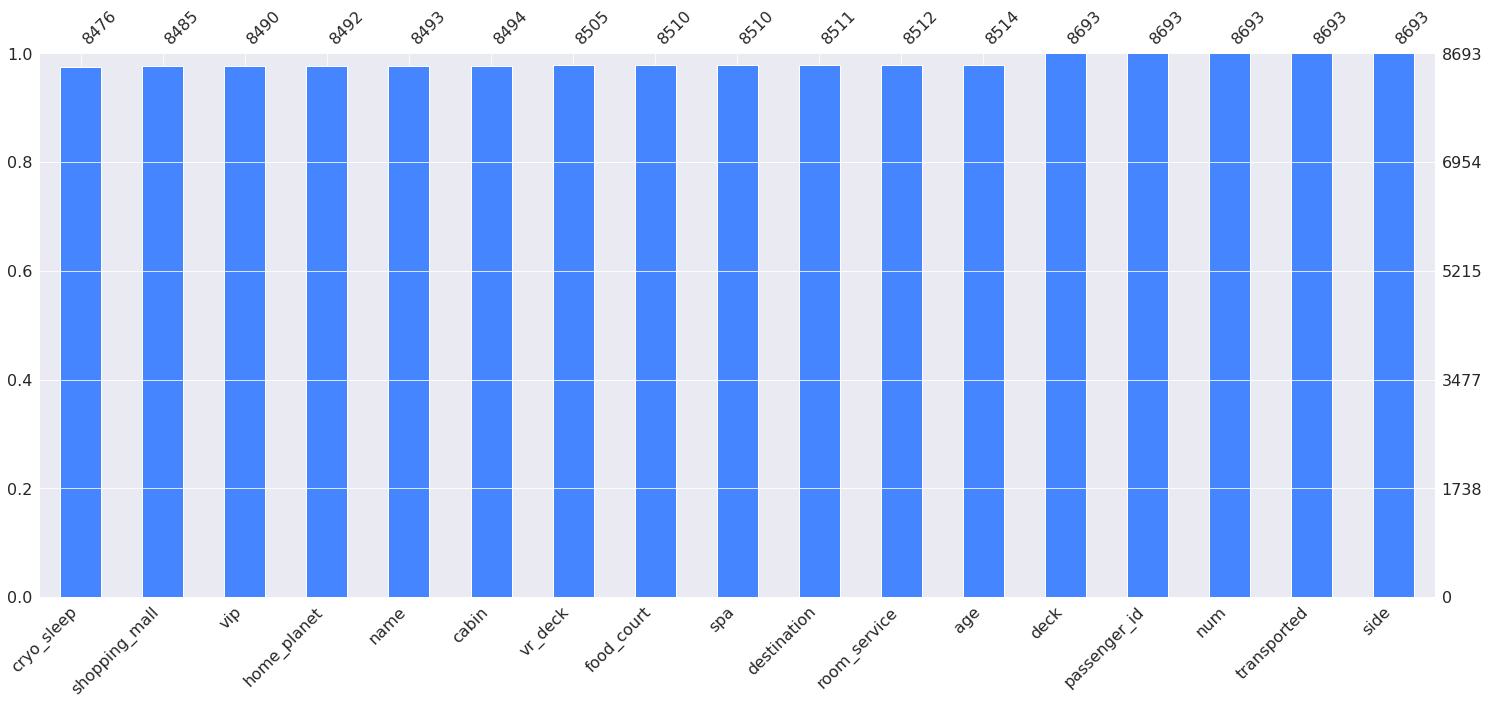

In [85]:
# Visual representation of the missing data
#msno.matrix(df_train, labels=True, sparkline=False, color=(0.27, 0.52, 1.0))
msno.bar(df_train, labels=True, sort='ascending', color=(0.27, 0.52, 1.0))

In [86]:
pd.DataFrame(df_train.isnull().sum(), columns = ['missing_count']).assign(missing_pct = lambda x: x['missing_count']/df_train.shape[0]*100)

,missing_count,missing_pct
passenger_id,0,0.000000
home_planet,201,2.312205
cryo_sleep,217,2.496261
cabin,199,2.289198
destination,182,2.093639
age,179,2.059128
vip,203,2.335212
room_service,181,2.082135
food_court,183,2.105142
shopping_mall,208,2.392730


In [87]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [88]:
pd.DataFrame(df_train.isnull().sum(), columns = ['missing_count']).assign(missing_pct = lambda x: x['missing_count']/df_train.shape[0]*100)

,missing_count,missing_pct
passenger_id,0,0.0
home_planet,0,0.0
cryo_sleep,0,0.0
cabin,0,0.0
destination,0,0.0
age,0,0.0
vip,0,0.0
room_service,0,0.0
food_court,0,0.0
shopping_mall,0,0.0


In [89]:
df_train.set_index(np.arange(0,6606), inplace=True)

In [90]:
df_train[0:5]

,passenger_id,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck,name,transported,deck,num,side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


In [91]:
df_train.tail()

,passenger_id,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck,name,transported,deck,num,side
6601,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,98,P
6602,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,1499,S
6603,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500,S
6604,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,608,S
6605,9280_02,Europa,False,E/608/S,TRAPPIST-1e,44.0,False,126.0,4688.0,0.0,0.0,12.0,Propsh Hontichre,True,E,608,S


In [92]:
df_train.nunique()

passenger_id     6606
home_planet         3
cryo_sleep          2
cabin            5305
destination         3
age                80
vip                 2
room_service     1093
food_court       1293
shopping_mall     984
spa              1143
vr_deck          1106
name             6590
transported         2
deck                8
num              1734
side                2
dtype: int64

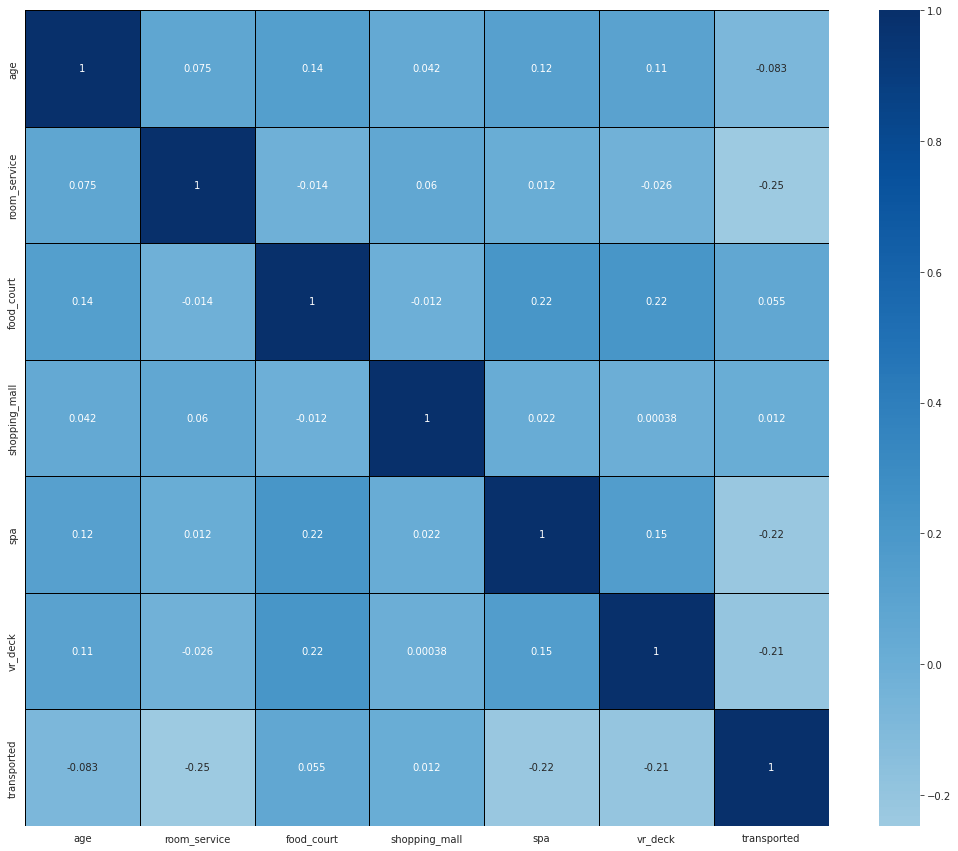

In [93]:
# Heat map to show correlation
plt.figure(figsize=(18,15))
sns.heatmap(df_train.corr(), cmap='Blues', annot=True, linewidths=.5, linecolor='black', center=0)
plt.show()
plt.close()

In [95]:
df_train['transported'].value_counts(normalize=True)

True     0.503633
False    0.496367
Name: transported, dtype: float64

In [97]:
df_train['cryo_sleep'].value_counts(normalize=True)

False    0.646988
True     0.353012
Name: cryo_sleep, dtype: float64

In [98]:
transported_pass = df_train[df_train['transported'] == True]
transported_pass.set_index(np.arange(0, 3327))

,passenger_id,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck,name,transported,deck,num,side
0,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
1,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S
2,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True,F,0,P
3,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True,F,2,S
4,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True,F,3,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3322,9270_01,Earth,True,G/1497/S,55 Cancri e,33.0,False,0.0,0.0,0.0,0.0,0.0,Lan Mckinsond,True,G,1497,S
3323,9272_01,Earth,False,G/1507/P,TRAPPIST-1e,26.0,False,240.0,242.0,510.0,0.0,0.0,Ireene Simson,True,G,1507,P
3324,9275_01,Europa,False,A/97/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Polaton Conable,True,A,97,P
3325,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500,S


In [99]:
print(transported_pass['transported'].value_counts())
print(transported_pass['cryo_sleep'].value_counts())

True    3327
Name: transported, dtype: int64
True     1905
False    1422
Name: cryo_sleep, dtype: int64


In [101]:
# Created a pivot table to view mean and median of home planet and age
df_train.pivot_table(values=['age'], index='home_planet', aggfunc=[np.mean, np.median], margins=True)

,mean,median
,age,age
home_planet,,
Earth,26.054683,24.0
Europa,34.572026,33.0
Mars,29.351865,28.0
All,28.894036,27.0


In [102]:
df_train.groupby('home_planet')['age'].agg([np.mean, np.median])

,mean,median
home_planet,,
Earth,26.054683,24.0
Europa,34.572026,33.0
Mars,29.351865,28.0


In [103]:
df_train['home_planet'].value_counts(normalize=True)

Earth     0.539812
Europa    0.253255
Mars      0.206933
Name: home_planet, dtype: float64

In [116]:
df_train.groupby('home_planet')['transported'].agg(np.mean)

home_planet
Earth     0.425687
Europa    0.659892
Mars      0.515728
Name: transported, dtype: float64

In [104]:
df_train['transported'].sum()

3327

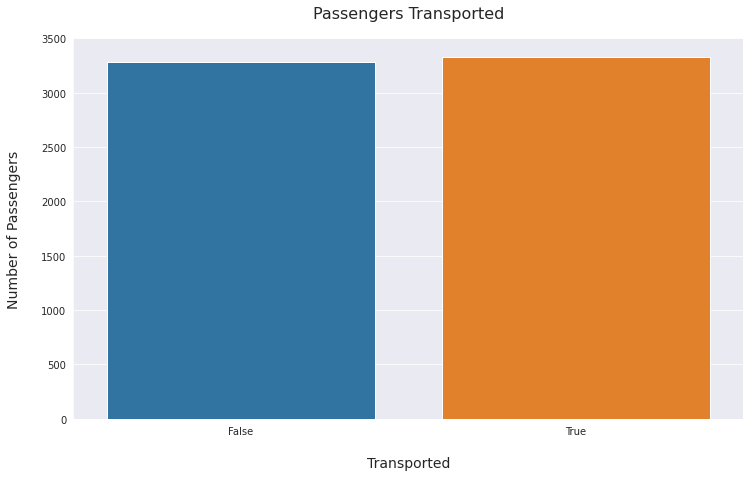

In [158]:
# Number of passengers transported. Shows more balanced data.
plt.figure(figsize=(12,7))
sns.countplot(x='transported', data=df_train)
plt.title("Passengers Transported", pad=20, fontsize=16)
plt.xlabel("Transported", labelpad=20, fontsize=14)
plt.ylabel("Number of Passengers", labelpad=20, fontsize=14)
plt.ylim(0, 3500)
plt.show()
plt.close()

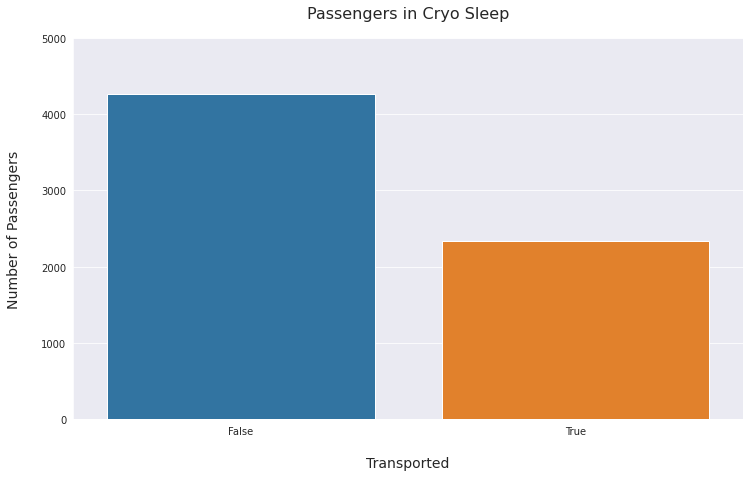

In [159]:
# Number of passsengers in cryo sleep
plt.figure(figsize=(12,7))
sns.countplot(x='cryo_sleep', data=df_train)
plt.title("Passengers in Cryo Sleep", pad=20, fontsize=16)
plt.xlabel("Transported", labelpad=20, fontsize=14)
plt.ylabel("Number of Passengers", labelpad=20, fontsize=14)
plt.ylim(0, 5000)
plt.show()
plt.close()

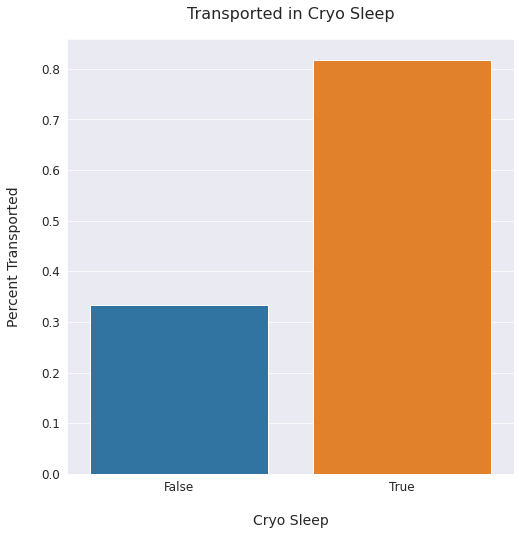

In [156]:
plt.figure(figsize=(8,8))
sns.barplot(x='cryo_sleep', y='transported', data=df_train, estimator=np.mean, ci=0)
plt.title('Transported in Cryo Sleep', pad=20, fontsize=16)
plt.xlabel('Cryo Sleep', labelpad=20, fontsize=14)
plt.ylabel('Percent Transported', labelpad=20, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

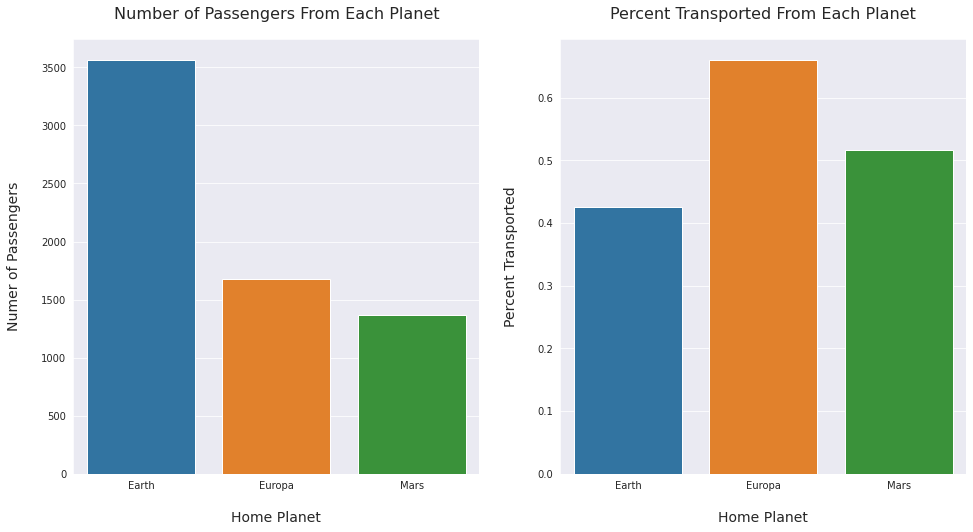

In [160]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
sns.countplot(x='home_planet', data=df_train, order=['Earth', 'Europa', 'Mars'], ax=ax[0])
sns.barplot(x='home_planet', y='transported', data=df_train, estimator=np.mean, order=['Earth', 'Europa', 'Mars'], ci=0, ax=ax[1])
ax[0].set_title('Number of Passengers From Each Planet', pad=20, fontsize=16)
ax[0].set_ylabel('Numer of Passengers', labelpad=20, fontsize=14)
ax[0].set_xlabel('Home Planet', labelpad=20, fontsize=14)
ax[1].set_title('Percent Transported From Each Planet', pad=20, fontsize=16)
ax[1].set_ylabel('Percent Transported', labelpad=20, fontsize=14)
ax[1].set_xlabel('Home Planet', labelpad=20, fontsize=14)
#df_train.groupby('home_planet')['transported'].agg(np.mean).plot(kind='bar')
#sns.catplot(x=df_train.groupby('home_planet')['transported'].sum(),kind='count', data=df_train)
plt.show()